In [7]:
from math import sqrt, acos, pi

from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import GroverOperator
from qiskit.transpiler import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2

import numpy as np

In [2]:
N = 4

In [3]:
def get_W(n:int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name="W(%d)"%(n))

    get_theta = lambda i : 2*acos(1/sqrt(i))

    base_value = n
    for qubit in range(0, n-1):
        if qubit == 0:
            qc.ry(get_theta(base_value), 0)
        else:
            qc.cry(get_theta(base_value), qubit-1, qubit)
        base_value -= 1

    for qubit in range(n-1, 0, -1):
        qc.cx(qubit-1,qubit)

    qc.x(0)

    return qc


In [4]:
def get_attacks_for_each_cell(cell):
    """
    Check the attacks for each queen position.
    """

    current_row, current_col = cell

    attacks = []


    for k in range(N):
        current_mapped_col = (k, current_col)
        current_mapped_row = (current_row, k)

        if current_mapped_row != cell:
            attacks.append(current_mapped_row)
        
        if current_mapped_col != cell:
            attacks.append(current_mapped_col)


    # top left
    current_i = current_row
    current_j = current_col
    while current_i > 0 and current_j > 0:
        current_i -= 1
        current_j -= 1
        attacks.append((current_i, current_j))

    # bottom right
    current_i = current_row
    current_j = current_col
    while current_i < N-1 and current_j < N-1:
        current_i += 1
        current_j += 1
        attacks.append((current_i, current_j))

    # top right 
    current_i = current_row
    current_j = current_col
    while current_i > 0 and current_j < N-1:
        current_i -= 1
        current_j += 1
        attacks.append((current_i, current_j))

    # bottom left 
    current_i = current_row
    current_j = current_col
    while current_i < N-1 and current_j > 0:
        current_i += 1
        current_j -= 1
        attacks.append((current_i, current_j))

    return attacks

In [5]:
def get_pos_mapping():
    mapping = {}
    k = 0
    for i in range(N):
        for j in range(N):
            mapping[(i,j)] = k
            k += 1
    return mapping

In [22]:
def check_line_of_qubits(n:int, qubits) -> bool:
    sorted_qubits = sorted(qubits)

    total_line = 0
    previous = sorted_qubits[0]
    for i in sorted_qubits[1:]:
        if(total_line == n):
            return True

        if(i == previous+1):
            total_line += 1
        else: 
            total_line = 0

        previous = i

    return False

In [23]:
def get_pattern(total_qubits, zeros, one):
    default_str = ['x']*total_qubits

    default_str[one] = '1'
    for zero in zeros:
        default_str[zero] = '0'
    
    return ''.join(default_str)

In [66]:
def get_oracle(n:int) -> QuantumCircuit:
    mapping = get_pos_mapping()
    
    total_qubits = n*n
    qc = QuantumCircuit(total_qubits, name="f(x)")


    patterns = set()

    for i in range(n):
        qc.barrier()
        for j in range(n):
            pos = (i,j)
            attacks = get_attacks_for_each_cell(pos)
            qubits = list(map(lambda x: mapping[x], attacks))

            if(check_line_of_qubits(n, qubits)):
                print("yeye")
                continue

            pos_qubit = mapping[pos]
            pattern = get_pattern(total_qubits, qubits, pos_qubit)
            reverse_pattern  = pattern[::-1]

            if (pattern in patterns or reverse_pattern in patterns):
                continue

            patterns.add(pattern)
            patterns.add(reverse_pattern)

            if not qubits:
                qc.z(0)
                continue

            qc.x(qubits)
            qc.mcp(-pi, qubits, pos_qubit)
            qc.x(qubits)
    print(patterns)
    return qc

In [67]:
get_oracle(N)

yeye
yeye
yeye
yeye
yeye
yeye
yeye
yeye
yeye
{'0010x0000x0xxx0x', '0xx0x0x0xx000001', '0001xx00x0x00xx0', 'x0xxx0x0000x0100', 'x0x0000x0100000x', '0xx00x0x00xx1000', 'x0000010x0000x0x', '0x0x00xx100000xx', '100000xx0x0x0xx0', 'xx000001xx00x0x0'}


In [27]:
def state_prep(n:int) -> QuantumCircuit:
    total_qubits = n*n
    qc = QuantumCircuit(total_qubits, name="W")

    for i in range(0,total_qubits, n):
        target_qubits = list(range(i,i+n))
        qc.append(get_W(n),target_qubits)
    return qc

In [61]:
def create_circuit(n:int) -> QuantumCircuit:
    total_qubits = n*n
    qc = QuantumCircuit(total_qubits)
    oracle = get_oracle(n)
    prep = state_prep(n)

    qc.append(prep, list(range(total_qubits)))
    for _ in range(142):
        qc.append(GroverOperator(oracle=oracle, state_preparation=prep), list(range(total_qubits)))
    qc.measure_all()
    return qc
    

{'10000x0x0', '001x000x0', '0x0x00001', 'x00001x00', '00x10000x', '0x000x100'}


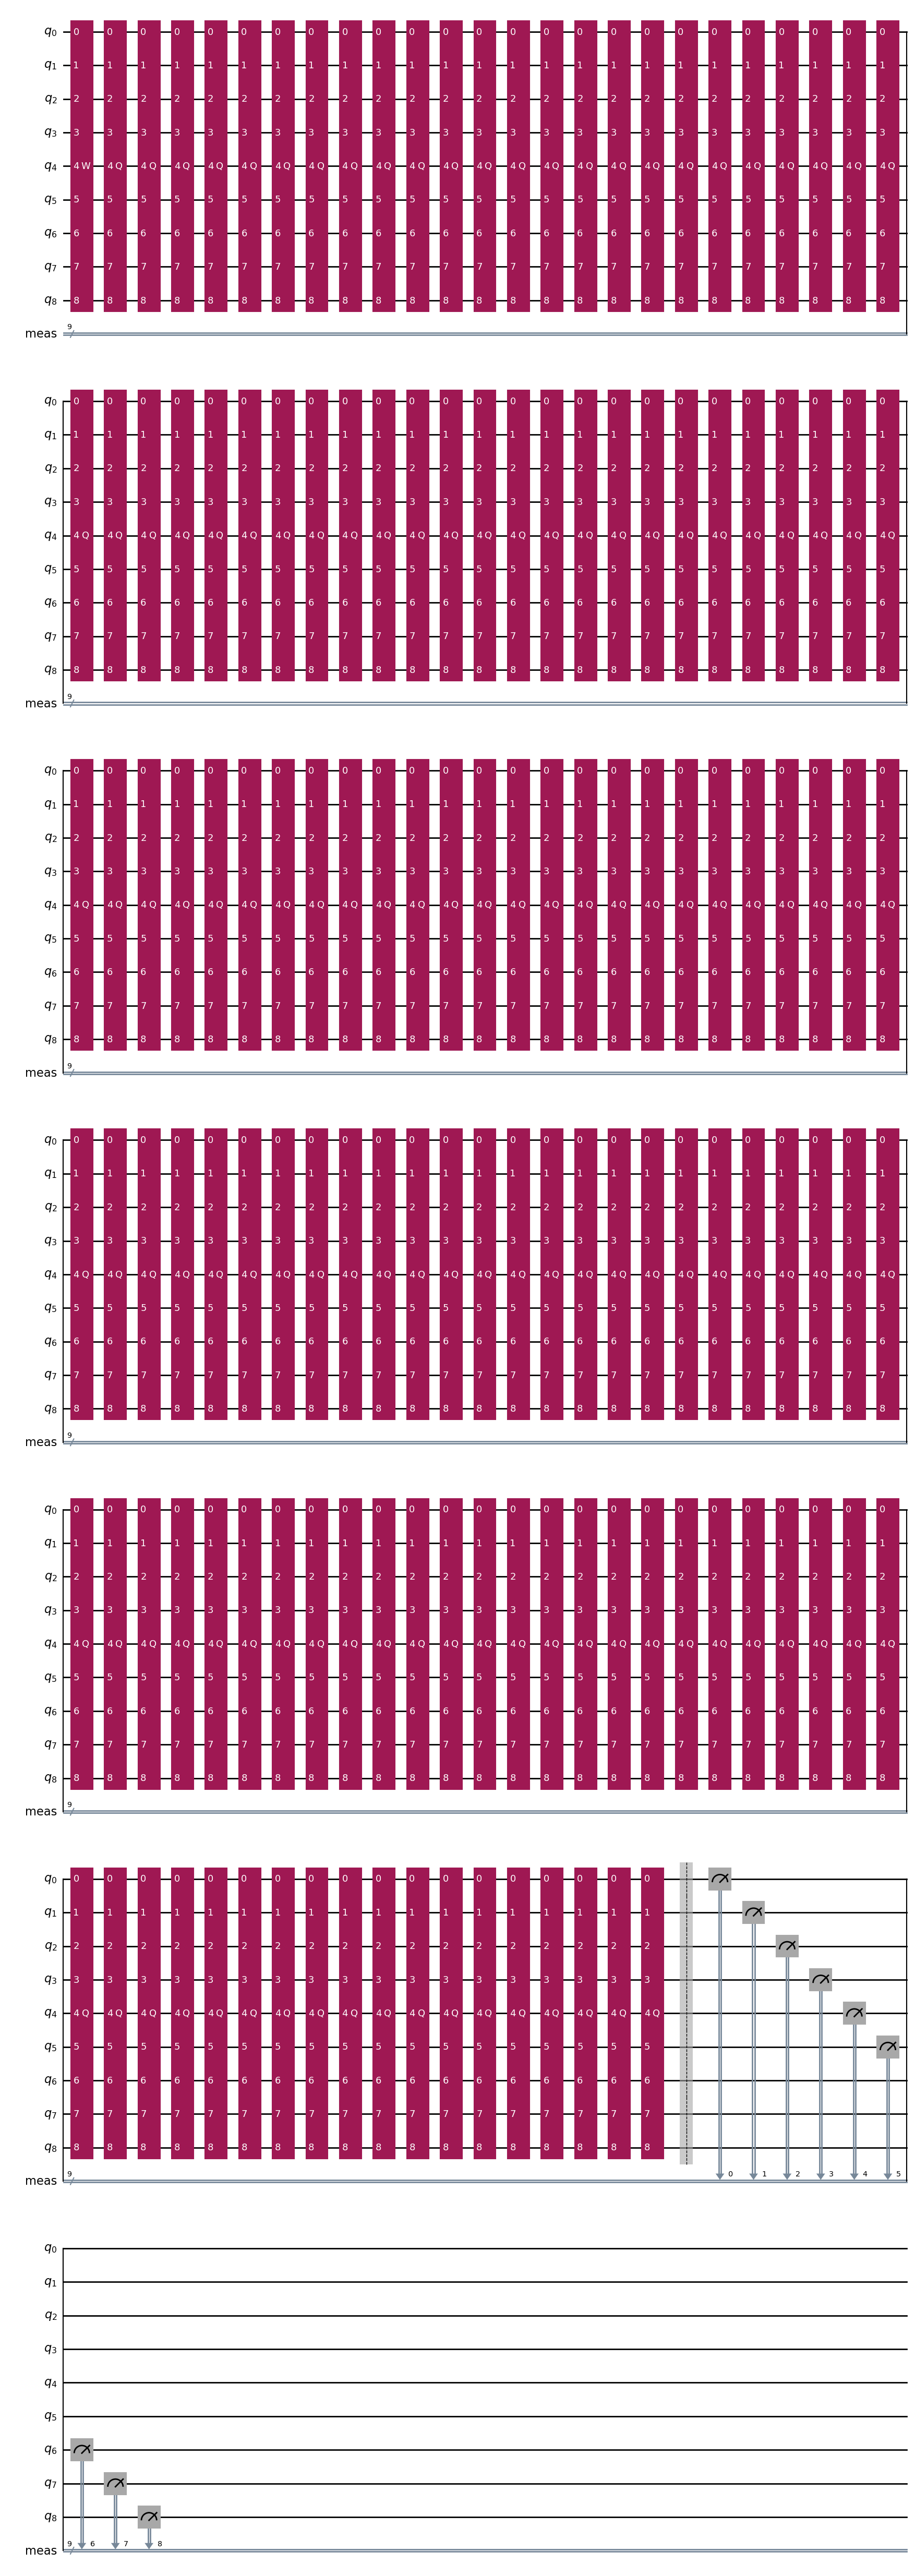

In [57]:
create_circuit(N).draw('mpl')

In [58]:
sim = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=0, backend=sim)
sampler = SamplerV2()


{'0010x0000x0xxx0x', '0xx0x0x0xx000001', '0001xx00x0x00xx0', 'x0xxx0x0000x0100', 'x0x0000x0100000x', '0xx00x0x00xx1000', 'x0000010x0000x0x', '0x0x00xx100000xx', '100000xx0x0x0xx0', 'xx000001xx00x0x0'}


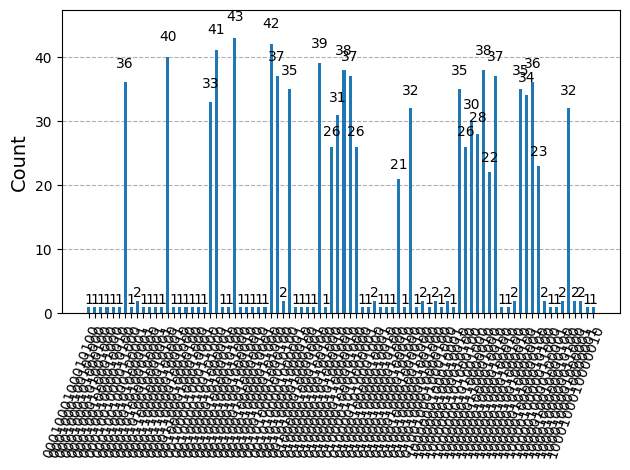

In [62]:
qc = create_circuit(N)
isa_qc = pm.run(qc)
result = sampler.run([isa_qc], shots=1000).result()
plot_histogram(result[0].data.meas.get_counts())

In [ ]:
# when we select a whole line to remove, we ignore it

In [17]:
from itertools import product

In [21]:
list(product([6,7],[9,11], [13,14]))
# we must use the product to create the combinations of values for each row that could be either 1 or zero (no attacks on these)

[(6, 9, 13),
 (6, 9, 14),
 (6, 11, 13),
 (6, 11, 14),
 (7, 9, 13),
 (7, 9, 14),
 (7, 11, 13),
 (7, 11, 14)]

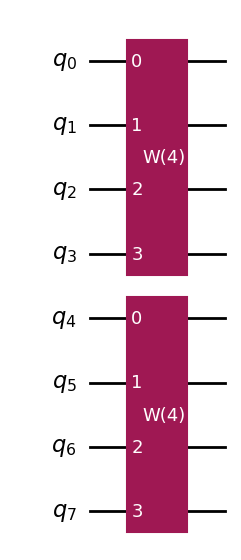

<IPython.core.display.Latex object>

In [ ]:
qc = QuantumCircuit(8)
qc.append(get_W(4), [0,  1,  2,  3])
qc.append(get_W(4), [4,  5,  6,  7])
qc.append(get_W(4), [8,  9,  10, 11])
qc.append(get_W(4), [12, 13, 14, 15])

x = [1,2,3,4,8,5,10]







display(qc.draw('mpl'))
Statevector(qc).draw('latex')


In [10]:
circOp = Operator.from_circuit(qc)
circOp.draw("latex")

<IPython.core.display.Latex object>

∣001001100⟩



In [ ]:
∣100001⟩

100
001

001
100

​
∣001100⟩

100
001

001
100

SyntaxError: invalid character '∣' (U+2223) (2913731217.py, line 1)